Next steps:
1. Add a "master node" that connects all nodes together, so that message passing works between all nodes

In [1]:
import pandas as pd

from EmbedDataset import LigandBinaryDataset

import time
import numpy as np
import torch
from torch_geometric.loader import DataLoader

In [2]:
dataset = LigandBinaryDataset('./data2/')

In [3]:
dataset = dataset.shuffle()
train_dataset = dataset[:int(len(dataset) * 0.7)]
val_dataset = dataset[int(len(dataset) * 0.7):int(len(dataset) * 0.85)]
test_dataset = dataset[int(len(dataset) * 0.85):]

In [4]:
train_dl = DataLoader(train_dataset, batch_size=16)
val_dl = DataLoader(val_dataset, batch_size=16)
test_dl = DataLoader(test_dataset, batch_size=16)

In [50]:
from LigandGNNV2 import LigandGNNV2
from LigandGNNV1 import LigandGNNV1
from sagn.models import SAGN

device = torch.device('cuda')
# model = LigandGNNV1(dataset.num_node_features, 1).to(device)
model = LigandGNNV2(80, 50).to(device)
# model = SAGN(in_feats=1070, hidden=1024, out_feats=1, num_hops=5, n_layers=2, num_heads=10).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([22]).to(device))

In [51]:
def train(model, loader, criterion, optimizer):
    model.train()

    loss_acc = 0.
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        label = data.y

        loss = criterion(output, label.reshape(-1, 1))
        loss.backward()
        loss_acc += data.num_graphs * loss.item()
        optimizer.step()

    return loss_acc / len(loader.dataset)

In [52]:
from sklearn.metrics import f1_score, precision_recall_curve, roc_curve, auc, precision_recall_fscore_support, roc_auc_score

def evaluate(model, loader):
    model.eval()

    preds = np.asarray([])
    labels = np.asarray([])

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            pred = torch.sigmoid(model(data).round().squeeze().cpu()).round().numpy()
            label = data.y.cpu().numpy()

            preds = np.concatenate([preds, pred])
            labels = np.concatenate([labels, label])

    precision, recall, _ = precision_recall_curve(labels, preds)
    fpr, tpr, thresholds = roc_curve(labels, preds, pos_label=1)
    print(precision_recall_fscore_support(labels, preds))
    return auc(fpr, tpr), auc(recall, precision)
    return roc_auc_score(labels, preds)

In [53]:
train_hist = []
val_hist = []

for epoch in range(1, 201):
    s = time.time()
    loss = train(model, train_dl, criterion, optimizer)
    train_score = evaluate(model, train_dl)
    val_score = evaluate(model, val_dl)
    scheduler.step(loss)
    e = time.time()

    train_hist.append(train_score)
    val_hist.append(val_score)

    if sum(val_score) > (.77 + .44) and sum(val_score) >= np.asarray(val_hist).sum(axis=1).max():
        print("saving...")
        torch.save(model.state_dict(), './models/BestModel3.pt')

    # print(f'Epoch: {epoch:03d}, Loss: {loss:.05f}, Train Score: {train_score:.05f}, Val Score: {val_score:.05f}, Time: {e - s:.05f}s')
    print(f'Epoch: {epoch:03d}, Loss: {loss:.05f}, Train Score: {train_score}, Val Score: {val_score}, Time: {e - s:.05f}s')

(array([0.97575537, 0.11371171]), array([0.89583358, 0.37516447]), array([0.93408804, 0.17452514]), array([341348,  12160], dtype=int64))
(array([0.97685669, 0.10955089]), array([0.87975427, 0.41512753]), array([0.92576621, 0.17335415]), array([63811,  2274], dtype=int64))
Epoch: 001, Loss: 1.19834, Train Score: (0.6354990255738395, 0.255184665011898), Val Score: (0.6474409014627037, 0.2724020060937617), Time: 13.00300s
(array([0.98148937, 0.10502642]), array([0.8297954 , 0.56069079]), array([0.89929025, 0.176914  ]), array([341348,  12160], dtype=int64))
(array([0.98385654, 0.10519327]), array([0.80990738, 0.62708883]), array([0.88844765, 0.18016425]), array([63811,  2274], dtype=int64))
Epoch: 002, Loss: 1.02105, Train Score: (0.6952430944450578, 0.3404143027925651), Val Score: (0.7184981064973551, 0.372557030723835), Time: 12.59800s
(array([0.97931248, 0.15258388]), array([0.90877345, 0.46110197]), array([0.94272529, 0.22929233]), array([341348,  12160], dtype=int64))
(array([0.9816

KeyboardInterrupt: 

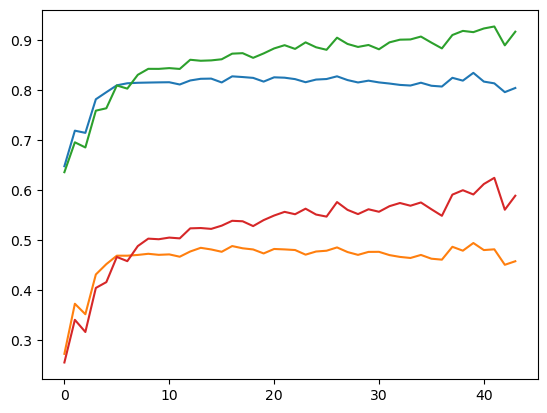

In [54]:
import matplotlib.pyplot as plt
plt.plot(val_hist)
plt.plot(train_hist)
plt.show()

In [55]:
evaluate(model, test_dl)

(array([0.98485135, 0.19955157]), array([0.90448544, 0.63120567]), array([0.94295915, 0.3032368 ]), array([74753,  2820], dtype=int64))


(0.7678455562351775, 0.4220819849164126)

In [58]:
model.load_state_dict(torch.load('./models/BestModel3.pt'))
evaluate(model, test_dl)

(array([0.98661438, 0.19632406]), array([0.89529517, 0.67801418]), array([0.93873916, 0.30448284]), array([74753,  2820], dtype=int64))


(0.7866546782486397, 0.44302167294425343)

In [56]:
data = test_dl.dataset[4].to(device)

In [14]:
pred = model(data)

In [15]:
out = torch.sigmoid(pred).round()
out

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
      

In [16]:
print(out.sum())
print(len(out))

tensor(65., device='cuda:0', grad_fn=<SumBackward0>)
403


In [17]:
len(data.y) / data.y.sum()

tensor(17.5217, device='cuda:0')

In [18]:
data.y.sum()

tensor(23., device='cuda:0')

In [19]:
f1_score(data.y.detach().cpu().numpy(), out.detach().cpu().numpy())

0.38636363636363635

In [ ]:
torch.save(model.state_dict(), './models/modelBest.pt')